In [2]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm 
import os

import args as params
from utils import load_dataset, get_hog_descriptors, get_class_labels, rescale, ImageData
from sliding_window import *
import pickle
from preprocess import readlabel


Using ORB


In [6]:
# load SVM from file
try:
    model = pickle.load(open(params.HOG_SVM_PATH, 'rb'))
except:
    print("[ERROR] Missing files - SVM!");
    print("[ERROR] Have you performed trained SVM to produce these files ?");
    


In [7]:
def topkboxes(detections, k=5, c_thresh = 0.7): 
    if k==1: return detections[np.argmax(detections[:, 4])]
    k_idxs = np.argsort(detections[:, 4])[-k:]
    topk = detections[k_idxs] # find best k
    bestk = np.where(topk[:, 4] > c_thresh) # choose only predictions >0.7
    if len(bestk)==0: return topk[np.argmax(topk[:, 4])] # if low confidence, return k
    return topk[bestk]

def mse_error(gt, preds):
    return np.sqrt(np.sum((gt-preds)**2))

def detector(img, model):
    detections = []
    multi_scales = [ 1.0, 1.25, 1.5] # [ 0.75, 1.0, 1.25, 1.5]

    ## for a range of different image scales in an image pyramid
    for current_scale in multi_scales:
        print(f"scale: {current_scale}")
        resized_img = rescale(img.copy(), current_scale)

        window_size = params.DATA_WINDOW_SIZE
        step = math.floor(resized_img.shape[0] / 32)
        if not (step > 0): continue    
        
        samples = {'feature' : [], 'xy' : [] }
        # Across each scan window
        window_slider = tqdm(sliding_window(resized_img, window_size, step_size=step))
        for (x, y, window) in window_slider: 
            

            # for each window region get the HOG feature point descriptors
            img_data = ImageData(window)
            img_data.compute_hog_descriptor() # note this image is 2.56x zoomed
            
            # generate and classify each window by constructing a HOG
            # descriptor and passing it through the SVM classifier
            if img_data.hog_descriptor is not None:
            
                # print("detecting with SVM ...")
                testdata = np.float32([img_data.hog_descriptor[:,0]])
                samples['feature'].append(testdata)
                samples['xy'].append((x, y))
                
                class_probability = model.predict_proba(testdata)
                pred_class = np.argmax(class_probability)
                
                # if we get a detection, then record it
                if pred_class == params.DATA_CLASS_NAMES["phone"]:
                    # store rect as (x1, y1) (x2,y2) pair
                    rect = np.float32([x, y, x + window_size[0], y + window_size[1]])
                    
                    rect /= current_scale
                    detections.append((rect, class_probability[0][pred_class]))
                    
    return np.array(detections)


0it [00:00, ?it/s]

############# Image 51.jpg #############


In [66]:
import time

def detector2(model, img):
    start = time.time()
    detections = []
    multi_scales = [ 1.0, 1.25] #, 1.5 [ 0.75, 1.0, 1.25, 1.5]
    win_samples = {'feature' : [], 'xy' : [], 'scale' : [] }
    ## for a range of different image scales in an image pyramid
    for current_scale in multi_scales:
        print(f"scale: {current_scale}")
        resized_img = rescale(img.copy(), current_scale)

        window_size = params.DATA_WINDOW_SIZE
        step = math.floor(resized_img.shape[0] / 64)
    
        # if not (step > 0): continue [UNCOMMENT]    

        # Across each scan window
        window_slider = tqdm(sliding_window(resized_img, window_size, step_size=step))
        for (x, y, window) in window_slider:         
            # for each window region get the HOG feature point descriptors
            img_data = ImageData(window)
            img_data.compute_hog_descriptor() # note this image is 2.56x zoomed
            # generate and classify each window by constructing a HOG
            # descriptor and passing it through the SVM classifier
            if img_data.hog_descriptor is not None:
                descriptor = np.float32([img_data.hog_descriptor[:,0]])
                win_samples['feature'].append(descriptor.squeeze())
                win_samples['xy'].append((x, y))
                win_samples['scale'].append(current_scale)



    print(f"total number of boxes: {len(np.array(win_samples['scale']))}")
    scales = np.array(win_samples['scale'])
    testdata = np.array(win_samples['feature'])
    class_probabilities = model.predict_proba(testdata)

    pred_classes = np.argmax(class_probabilities, axis=1)
    idxs = np.where(pred_classes == params.DATA_CLASS_NAMES["phone"])[0]

    confidences = class_probabilities[idxs][:, params.DATA_CLASS_NAMES["phone"]]
    locations = np.array(win_samples['xy'])[idxs]
    scales = np.array(win_samples['scale'])[idxs][:, np.newaxis]
    xmin = locations[:,0][:, np.newaxis]
    ymin = locations[:,1][:, np.newaxis]
    xmax = xmin + window_size[0] 
    ymax = ymin + window_size[1]

    rectangles = np.hstack((xmin/scales,ymin/scales, xmax/scales, ymax/scales)) 
    detections = np.hstack([rectangles, confidences[:, np.newaxis]])
    time_elapsed = time.time()-start
    print(f" Total time for detection: {time_elapsed}")
    return detections


lines = readlabel(params.label_path)[: 20]

N = len(lines)
correct = 0
for i, line in tqdm(enumerate(lines)):
    name, x, y =  line.rsplit(' ')
    print(f"############# Image {name} #############")
    x, y = float(x), float(y) 
    img = cv2.imread(f'{params.data_path}/{name}')
    h,w = img.shape[:2]
    cx, cy = int(x*w), int(y*h)
    
    detections = detector2(model, img)
    topk_detections = topkboxes(detections)
    boxes = topk_detections[:, :4]
    box = np.mean(boxes, axis=0) # regular mean of k boxes
    pred_cx, pred_cy = np.mean((box[0], box[2])), np.mean((box[1], box[3])) # center

    gt = np.array([cx/w, cy/h])
    preds = np.array([pred_cx/w, pred_cy/h])

    if mse_error(gt,  preds) < 0.05 :
        print("Correct prediction")
        correct+=1
    else:
        print("Wrong prediction")

In [5]:
lines = readlabel(params.label_path)[: 20]

N = len(lines)
correct = 0
for i, line in tqdm(enumerate(lines)):

    name, x, y =  line.rsplit(' ')
    print(f"############# Image {name} #############")
    x, y = float(x), float(y) 
    img = cv2.imread(f'{params.data_path}/{name}')
    h,w = img.shape[:2]
    cx, cy = int(x*w), int(y*h)

    # detect all boxes
    detections = detector(img, model)

    # take top k boxes 
    topk_detections = topkboxes(detections)

    # compute centroid of k boxes
    box = np.mean(topk_detections[:,0], axis=0) # regular mean of k boxes
    pred_cx, pred_cy = np.mean((box[0], box[2])), np.mean((box[1], box[3])) # center

    gt = np.array([cx/w, cy/h])
    preds = np.array([pred_cx/w, pred_cy/h])

    if mse_error(gt,  preds) < 0.05 :
        correct+=1
        

0it [00:00, ?it/s]

############# Image 51.jpg #############
scale: 1.0


1260it [00:08, 150.76it/s]


scale: 1.25


1410it [00:09, 152.98it/s]


scale: 1.5


1380it [00:09, 152.53it/s]
1it [00:26, 26.68s/it]

############# Image 95.jpg #############
scale: 1.0


1260it [00:08, 152.86it/s]


scale: 1.25


1410it [00:09, 150.28it/s]


scale: 1.5


1380it [00:08, 153.39it/s]
2it [00:53, 26.65s/it]

############# Image 84.jpg #############
scale: 1.0


1260it [00:08, 147.70it/s]


scale: 1.25


1410it [00:09, 150.83it/s]


scale: 1.5


1380it [00:08, 154.71it/s]
3it [01:20, 26.73s/it]

############# Image 118.jpg #############
scale: 1.0


1260it [00:08, 151.09it/s]


scale: 1.25


1410it [00:09, 152.39it/s]


scale: 1.5


1380it [00:09, 152.01it/s]
4it [01:46, 26.71s/it]

############# Image 115.jpg #############
scale: 1.0


1260it [00:08, 151.07it/s]


scale: 1.25


1410it [00:09, 154.40it/s]


scale: 1.5


1380it [00:09, 152.16it/s]
5it [02:13, 26.65s/it]

############# Image 33.jpg #############
scale: 1.0


1260it [00:08, 153.38it/s]


scale: 1.25


1410it [00:09, 151.78it/s]


scale: 1.5


1380it [00:08, 154.64it/s]
6it [02:39, 26.58s/it]

############# Image 58.jpg #############
scale: 1.0


1260it [00:08, 149.81it/s]


scale: 1.25


1410it [00:09, 153.67it/s]


scale: 1.5


1380it [00:08, 153.69it/s]
7it [03:06, 26.58s/it]

############# Image 119.jpg #############
scale: 1.0


1260it [00:08, 152.61it/s]


scale: 1.25


1410it [00:09, 153.00it/s]


scale: 1.5


1380it [00:09, 149.01it/s]
8it [03:33, 26.63s/it]

############# Image 38.jpg #############
scale: 1.0


1260it [00:08, 151.48it/s]


scale: 1.25


1410it [00:09, 149.87it/s]


scale: 1.5


1380it [00:09, 149.66it/s]
9it [04:00, 26.73s/it]

############# Image 8.jpg #############
scale: 1.0


1260it [00:08, 150.97it/s]


scale: 1.25


1410it [00:09, 150.07it/s]


scale: 1.5


1380it [00:09, 149.96it/s]
10it [04:27, 26.80s/it]

############# Image 47.jpg #############
scale: 1.0


1260it [00:08, 151.63it/s]


scale: 1.25


1410it [00:09, 151.59it/s]


scale: 1.5


1380it [00:09, 151.10it/s]
11it [04:53, 26.79s/it]

############# Image 131.jpg #############
scale: 1.0


1260it [00:08, 147.72it/s]


scale: 1.25


1410it [00:09, 150.68it/s]


scale: 1.5


1380it [00:09, 151.73it/s]
12it [05:20, 26.85s/it]

############# Image 48.jpg #############
scale: 1.0


1260it [00:08, 154.59it/s]


scale: 1.25


1410it [00:09, 155.62it/s]


scale: 1.5


1380it [00:09, 149.10it/s]
13it [05:47, 26.74s/it]

############# Image 130.jpg #############
scale: 1.0


1260it [00:08, 153.37it/s]


scale: 1.25


1410it [00:09, 155.60it/s]


scale: 1.5


1380it [00:08, 155.09it/s]
14it [06:13, 26.57s/it]

############# Image 93.jpg #############
scale: 1.0


1260it [00:08, 149.94it/s]


scale: 1.25


1410it [00:09, 152.02it/s]


scale: 1.5


1380it [00:08, 153.38it/s]
15it [06:40, 26.61s/it]

############# Image 50.jpg #############
scale: 1.0


1260it [00:08, 153.95it/s]


scale: 1.25


1410it [00:08, 157.04it/s]


scale: 1.5


1380it [00:08, 154.86it/s]
16it [07:06, 26.45s/it]

############# Image 112.jpg #############
scale: 1.0


1260it [00:08, 153.21it/s]


scale: 1.25


1410it [00:09, 154.65it/s]


scale: 1.5


1380it [00:09, 150.62it/s]
17it [07:32, 26.47s/it]

############# Image 121.jpg #############
scale: 1.0


1260it [00:08, 152.32it/s]


scale: 1.25


1410it [00:09, 156.42it/s]


scale: 1.5


1380it [00:09, 152.61it/s]
18it [07:59, 26.43s/it]

############# Image 97.jpg #############
scale: 1.0


1260it [00:08, 150.95it/s]


scale: 1.25


1410it [00:09, 154.67it/s]


scale: 1.5


1380it [00:09, 153.16it/s]
19it [08:25, 26.45s/it]

############# Image 120.jpg #############
scale: 1.0


1260it [00:08, 153.88it/s]


scale: 1.25


1410it [00:09, 151.60it/s]


scale: 1.5


1380it [00:09, 151.54it/s]
20it [08:52, 26.61s/it]


In [ ]:
print(f"accuracy = {correct/N}")


0it [00:00, ?it/s]


accuracy = 0.7


In [ ]:
# # for a range of different image scales in an image pyramid
# current_scale = -1
# detections = []
# rescaling_factor = 1.25


# for resized in pyramid(img, scale=rescaling_factor): # Across Multiple Scale

#     # at the start our scale = 1, because we catch the flag value -1   
#     # after this rescale downwards each time (division by re-scale factor)
#     current_scale = 1 if (current_scale == -1) else current_scale /rescaling_factor 

#     rect_img = resized.copy()

#     # [DEBUGGER] if we want to see progress show each scale
#     # if (show_scan_window_process):
#         # cv2.imshow('current scale',rect_img)
#         # cv2.waitKey(10);

#     # loop over the sliding window for each layer of the pyramid (re-sized image)
#     window_size = params.DATA_WINDOW_SIZE
#     step = math.floor(resized.shape[0] / 16)

#     if step > 0:
#         ############################# for each scan window

#         for (x, y, window) in sliding_window(resized, window_size, step_size=step):
            
#             ## [DEBUGGER] if we want to see progress show each scan window
#             # if (show_scan_window_process):
#             #     cv2.imshow('current window',window)
#             #     key = cv2.waitKey(10) # wait 10ms

#             # for each window region get the HOG feature point descriptors
#             img_data = ImageData(window)
#             img_data.compute_hog_descriptor() # note this image is 2.56x zoomed
            

#             # generate and classify each window by constructing a BoW
#             # histogram and passing it through the SVM classifier
#             if img_data.hog_descriptor is not None:
#                 # print("detecting with SVM ...")
#                 retval, [result] = svm.predict(np.float32([img_data.hog_descriptor]))
#                 # if we get a detection, then record it
#                 if result[0] == params.DATA_CLASS_NAMES["phone"]:
#                     # store rect as (x1, y1) (x2,y2) pair
#                     rect = np.float32([x, y, x + window_size[0], y + window_size[1]])
                    
#                     # [DEBUGGER] 
#                     # if (show_scan_window_process):
#                     #     cv2.rectangle(rect_img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 0, 255), 2)
#                     #     cv2.imshow('current scale',rect_img)
#                     #     cv2.waitKey(40)                                        
#                     # rect *= (1.0 / current_scale)
#                     detections.append(rect)


In [ ]:
# # for a range of different image scales in an image pyramid
# current_scale = -1
# detections = []
# rescaling_factor = 1.25


# for resized in pyramid(img, scale=rescaling_factor): # Across Multiple Scale

#     # at the start our scale = 1, because we catch the flag value -1   
#     # after this rescale downwards each time (division by re-scale factor)
#     current_scale = 1 if (current_scale == -1) else current_scale /rescaling_factor 

#     rect_img = resized.copy()

#     # [DEBUGGER] if we want to see progress show each scale
#     # if (show_scan_window_process):
#         # cv2.imshow('current scale',rect_img)
#         # cv2.waitKey(10);

#     # loop over the sliding window for each layer of the pyramid (re-sized image)
#     window_size = params.DATA_WINDOW_SIZE
#     step = math.floor(resized.shape[0] / 16)

#     if step > 0:
#         ############################# for each scan window

#         for (x, y, window) in sliding_window(resized, window_size, step_size=step):
            
#             ## [DEBUGGER] if we want to see progress show each scan window
#             # if (show_scan_window_process):
#             #     cv2.imshow('current window',window)
#             #     key = cv2.waitKey(10) # wait 10ms

#             # for each window region get the HOG feature point descriptors
#             img_data = ImageData(window)
#             img_data.compute_hog_descriptor() # note this image is 2.56x zoomed
            

#             # generate and classify each window by constructing a BoW
#             # histogram and passing it through the SVM classifier
#             if img_data.hog_descriptor is not None:
#                 # print("detecting with SVM ...")
#                 retval, [result] = svm.predict(np.float32([img_data.hog_descriptor]))
#                 # if we get a detection, then record it
#                 if result[0] == params.DATA_CLASS_NAMES["phone"]:
#                     # store rect as (x1, y1) (x2,y2) pair
#                     rect = np.float32([x, y, x + window_size[0], y + window_size[1]])
                    
#                     # [DEBUGGER] 
#                     # if (show_scan_window_process):
#                     #     cv2.rectangle(rect_img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 0, 255), 2)
#                     #     cv2.imshow('current scale',rect_img)
#                     #     cv2.waitKey(40)                                        
#                     # rect *= (1.0 / current_scale)
#                     detections.append(rect)


116.666664 206.66666


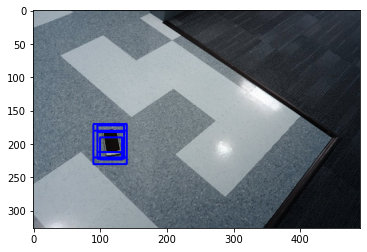

In [26]:


for box, confidence in topk:
    cv2.rectangle(output_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
    plt.imshow(output_img)


print(pred_cx, pred_cy )

(236.66666, 146.66666)

In [28]:
detections

array([[array([225. ,  22.5, 300. ,  97.5], dtype=float32),
        0.5626897228667034],
       [array([855. ,  22.5, 930. ,  97.5], dtype=float32),
        0.59874614683168],
       [array([922.5,  22.5, 997.5,  97.5], dtype=float32),
        0.7498444000085136],
       [array([ 45.,  45., 120., 120.], dtype=float32),
        0.6490068153137056],
       [array([877.5,  45. , 952.5, 120. ], dtype=float32),
        0.5275392277544603],
       [array([900.,  45., 975., 120.], dtype=float32),
        0.6574486750529961],
       [array([ 45. ,  67.5, 120. , 142.5], dtype=float32),
        0.5556928317073567],
       [array([855. ,  67.5, 930. , 142.5], dtype=float32),
        0.8457350375175218],
       [array([877.5,  67.5, 952.5, 142.5], dtype=float32),
        0.9412904355275523],
       [array([877.5,  90. , 952.5, 165. ], dtype=float32),
        0.7017281952022465],
       [array([922.5,  90. , 997.5, 165. ], dtype=float32),
        0.6491650845084235],
       [array([  0. , 112.5,  7

In [12]:

# For the overall set of detections (over all scales) perform
# non maximal suppression (i.e. remove overlapping boxes etc).
# detections = non_max_suppression_fast(np.int32(detections), 0.4)


# finally draw all the detection on the original image
for rect in detections:



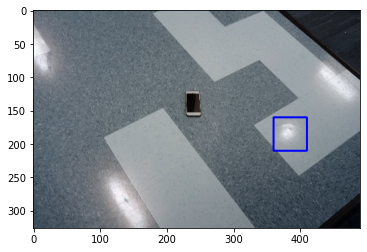

In [69]:
plt.imshow(output_img)